In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles

In [2]:
if torch.cuda.is_available():
  device = "cuda"
elif torch.backends.mps.is_available():
  device = "mps"
else:
  device = "cpu"
print(f"using device: {device}")

using device: cpu


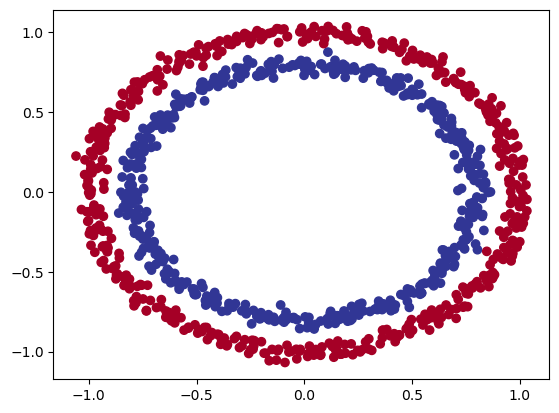

In [3]:
X_c,y_c = make_circles(n_samples=1000, noise=0.03, random_state=42)
plt.scatter(X_c[:,0],X_c[:, 1], c=y_c, cmap=plt.cm.RdYlBu);

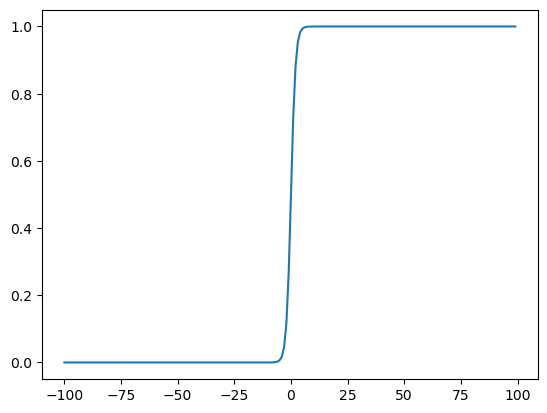

In [4]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

X = np.arange (-100,100,1)
y = [sigmoid(value) for value in X]
plt.plot(X,y)

In [5]:
X_tensor = torch.from_numpy(X_c).type(torch.float)
y_tensor = torch.from_numpy(np.array(y_c)).type(torch.float)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

In [7]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self,x):
        x = self.layer_1(x)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.relu(x)
        x = self.layer_3(x)
        return x
        

In [8]:
model = Model()
list(model.parameters())

[Parameter containing:
 tensor([[ 0.6862,  0.1015],
         [ 0.3723, -0.2764],
         [-0.0598,  0.5880],
         [ 0.5806,  0.4157],
         [ 0.6552,  0.4831],
         [ 0.5568, -0.5539],
         [-0.1732, -0.3812],
         [-0.1871, -0.3756],
         [ 0.3118, -0.2851],
         [ 0.2293, -0.2748]], requires_grad=True),
 Parameter containing:
 tensor([-0.4570,  0.2014,  0.2288,  0.6316,  0.0368, -0.4523,  0.2647, -0.6650,
          0.1874,  0.2770], requires_grad=True),
 Parameter containing:
 tensor([[ 0.1625,  0.1725,  0.1362, -0.0907,  0.0780, -0.0128, -0.0312,  0.0414,
           0.1863, -0.2020],
         [-0.2379, -0.2124, -0.1280, -0.1837, -0.1480, -0.2115,  0.2684, -0.1589,
          -0.0913, -0.1609],
         [ 0.2110, -0.1624, -0.2639,  0.1318,  0.2571, -0.0946,  0.2564, -0.2935,
          -0.1768, -0.0816],
         [-0.2327,  0.2453, -0.0358, -0.0437, -0.0693, -0.0094,  0.0936,  0.0804,
           0.1061, -0.3054],
         [-0.0826,  0.1893, -0.1433,  0.2530,

In [9]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    accuracy = (correct/len(y_pred))*100
    return accuracy

In [10]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.05) #lr=learning rate

In [11]:
from tqdm import tqdm

In [15]:
epochs = 5000
torch.cuda.manual_seed(42)
model.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
for epoch in tqdm(range(epochs)):
    ###training
    model.train()
    # 1. Forward Pass
    y_logits = model(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    # 2. Compute Train Loss
    train_loss = loss_fn(y_logits, y_train)
    # 3. zero Grad the optimizer
    optimizer.zero_grad()
    # 4. Backpropagate
    train_loss.backward()
    # 5. Step the optimizer
    optimizer.step()
    train_acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

    ###Testing
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,y_test)
        test_acc= accuracy_fn(y_true=y_test,y_pred=test_preds)
    if(epoch+1)%100==00:
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.3f}| Train Acc: {train_acc:.2f} | Test Loss: {test_loss:.3f}| Test Acc: {test_acc:.2f}")


  3%|██▋                                                                           | 169/5000 [00:00<00:12, 372.54it/s]

Epoch: 99 | Train Loss: 0.667| Train Acc: 70.88 | Test Loss: 0.674| Test Acc: 65.00


  4%|███▏                                                                          | 207/5000 [00:00<00:14, 339.56it/s]

Epoch: 199 | Train Loss: 0.660| Train Acc: 71.62 | Test Loss: 0.668| Test Acc: 67.00


  6%|████▉                                                                         | 313/5000 [00:01<00:19, 241.22it/s]

Epoch: 299 | Train Loss: 0.650| Train Acc: 74.50 | Test Loss: 0.661| Test Acc: 67.00


  9%|███████▏                                                                      | 458/5000 [00:01<00:14, 309.96it/s]

Epoch: 399 | Train Loss: 0.637| Train Acc: 79.12 | Test Loss: 0.650| Test Acc: 71.50


 11%|████████▉                                                                     | 569/5000 [00:02<00:13, 339.48it/s]

Epoch: 499 | Train Loss: 0.619| Train Acc: 84.38 | Test Loss: 0.635| Test Acc: 77.50


 13%|█████████▉                                                                    | 641/5000 [00:02<00:12, 337.81it/s]

Epoch: 599 | Train Loss: 0.593| Train Acc: 89.88 | Test Loss: 0.613| Test Acc: 84.50


 14%|███████████▏                                                                  | 720/5000 [00:02<00:15, 273.62it/s]

Epoch: 699 | Train Loss: 0.558| Train Acc: 93.50 | Test Loss: 0.582| Test Acc: 91.00


 17%|█████████████▌                                                                | 872/5000 [00:03<00:11, 349.97it/s]

Epoch: 799 | Train Loss: 0.511| Train Acc: 95.88 | Test Loss: 0.539| Test Acc: 93.50


 19%|██████████████▊                                                               | 951/5000 [00:03<00:11, 362.47it/s]

Epoch: 899 | Train Loss: 0.451| Train Acc: 97.75 | Test Loss: 0.485| Test Acc: 93.50


 21%|████████████████▍                                                            | 1066/5000 [00:03<00:10, 357.73it/s]

Epoch: 999 | Train Loss: 0.382| Train Acc: 98.75 | Test Loss: 0.422| Test Acc: 95.50


 23%|█████████████████▌                                                           | 1140/5000 [00:03<00:10, 360.60it/s]

Epoch: 1099 | Train Loss: 0.310| Train Acc: 99.50 | Test Loss: 0.353| Test Acc: 97.50


 25%|███████████████████▎                                                         | 1256/5000 [00:04<00:09, 377.60it/s]

Epoch: 1199 | Train Loss: 0.244| Train Acc: 99.88 | Test Loss: 0.288| Test Acc: 98.50


 28%|█████████████████████▏                                                       | 1376/5000 [00:04<00:09, 373.02it/s]

Epoch: 1299 | Train Loss: 0.190| Train Acc: 100.00 | Test Loss: 0.232| Test Acc: 99.00


 29%|██████████████████████▎                                                      | 1452/5000 [00:04<00:09, 363.14it/s]

Epoch: 1399 | Train Loss: 0.148| Train Acc: 100.00 | Test Loss: 0.188| Test Acc: 99.50


 31%|████████████████████████▏                                                    | 1567/5000 [00:04<00:09, 367.77it/s]

Epoch: 1499 | Train Loss: 0.118| Train Acc: 100.00 | Test Loss: 0.155| Test Acc: 99.50


 33%|█████████████████████████▏                                                   | 1639/5000 [00:05<00:09, 346.02it/s]

Epoch: 1599 | Train Loss: 0.095| Train Acc: 100.00 | Test Loss: 0.129| Test Acc: 99.50


 35%|██████████████████████████▉                                                  | 1750/5000 [00:05<00:09, 354.67it/s]

Epoch: 1699 | Train Loss: 0.079| Train Acc: 100.00 | Test Loss: 0.110| Test Acc: 99.50


 38%|████████████████████████████▉                                                | 1875/5000 [00:05<00:08, 375.12it/s]

Epoch: 1799 | Train Loss: 0.066| Train Acc: 100.00 | Test Loss: 0.095| Test Acc: 99.50


 39%|██████████████████████████████                                               | 1949/5000 [00:05<00:08, 351.65it/s]

Epoch: 1899 | Train Loss: 0.056| Train Acc: 100.00 | Test Loss: 0.083| Test Acc: 99.50


 41%|███████████████████████████████▊                                             | 2066/5000 [00:06<00:08, 359.50it/s]

Epoch: 1999 | Train Loss: 0.049| Train Acc: 100.00 | Test Loss: 0.074| Test Acc: 99.50


 43%|████████████████████████████████▉                                            | 2140/5000 [00:06<00:08, 350.93it/s]

Epoch: 2099 | Train Loss: 0.043| Train Acc: 100.00 | Test Loss: 0.066| Test Acc: 99.50


 45%|██████████████████████████████████▋                                          | 2251/5000 [00:06<00:07, 348.08it/s]

Epoch: 2199 | Train Loss: 0.038| Train Acc: 100.00 | Test Loss: 0.060| Test Acc: 99.50


 47%|████████████████████████████████████▍                                        | 2370/5000 [00:07<00:07, 366.73it/s]

Epoch: 2299 | Train Loss: 0.034| Train Acc: 100.00 | Test Loss: 0.055| Test Acc: 100.00


 49%|█████████████████████████████████████▋                                       | 2444/5000 [00:07<00:07, 345.39it/s]

Epoch: 2399 | Train Loss: 0.031| Train Acc: 100.00 | Test Loss: 0.050| Test Acc: 100.00


 51%|███████████████████████████████████████▍                                     | 2562/5000 [00:07<00:06, 366.68it/s]

Epoch: 2499 | Train Loss: 0.028| Train Acc: 100.00 | Test Loss: 0.047| Test Acc: 100.00


 54%|█████████████████████████████████████████▏                                   | 2676/5000 [00:08<00:06, 361.09it/s]

Epoch: 2599 | Train Loss: 0.026| Train Acc: 100.00 | Test Loss: 0.044| Test Acc: 100.00


 55%|██████████████████████████████████████████▍                                  | 2758/5000 [00:08<00:05, 382.87it/s]

Epoch: 2699 | Train Loss: 0.024| Train Acc: 100.00 | Test Loss: 0.041| Test Acc: 100.00


 57%|███████████████████████████████████████████▊                                 | 2846/5000 [00:08<00:05, 394.64it/s]

Epoch: 2799 | Train Loss: 0.022| Train Acc: 100.00 | Test Loss: 0.039| Test Acc: 100.00


 60%|█████████████████████████████████████████████▉                               | 2985/5000 [00:08<00:04, 444.90it/s]

Epoch: 2899 | Train Loss: 0.021| Train Acc: 100.00 | Test Loss: 0.036| Test Acc: 100.00


 61%|███████████████████████████████████████████████▎                             | 3073/5000 [00:09<00:04, 406.55it/s]

Epoch: 2999 | Train Loss: 0.019| Train Acc: 100.00 | Test Loss: 0.035| Test Acc: 100.00


 63%|████████████████████████████████████████████████▊                            | 3172/5000 [00:09<00:04, 449.56it/s]

Epoch: 3099 | Train Loss: 0.018| Train Acc: 100.00 | Test Loss: 0.033| Test Acc: 100.00


 65%|██████████████████████████████████████████████████▎                          | 3267/5000 [00:09<00:03, 452.30it/s]

Epoch: 3199 | Train Loss: 0.017| Train Acc: 100.00 | Test Loss: 0.031| Test Acc: 100.00


 67%|███████████████████████████████████████████████████▋                         | 3359/5000 [00:09<00:03, 438.16it/s]

Epoch: 3299 | Train Loss: 0.016| Train Acc: 100.00 | Test Loss: 0.030| Test Acc: 100.00


 69%|█████████████████████████████████████████████████████                        | 3448/5000 [00:09<00:03, 406.50it/s]

Epoch: 3399 | Train Loss: 0.015| Train Acc: 100.00 | Test Loss: 0.029| Test Acc: 100.00


 72%|███████████████████████████████████████████████████████                      | 3577/5000 [00:10<00:03, 409.97it/s]

Epoch: 3499 | Train Loss: 0.014| Train Acc: 100.00 | Test Loss: 0.028| Test Acc: 100.00


 73%|████████████████████████████████████████████████████████▌                    | 3670/5000 [00:10<00:03, 427.92it/s]

Epoch: 3599 | Train Loss: 0.014| Train Acc: 100.00 | Test Loss: 0.027| Test Acc: 100.00


 75%|█████████████████████████████████████████████████████████▊                   | 3756/5000 [00:10<00:03, 408.20it/s]

Epoch: 3699 | Train Loss: 0.013| Train Acc: 100.00 | Test Loss: 0.026| Test Acc: 100.00


 78%|███████████████████████████████████████████████████████████▊                 | 3881/5000 [00:10<00:02, 397.07it/s]

Epoch: 3799 | Train Loss: 0.012| Train Acc: 100.00 | Test Loss: 0.025| Test Acc: 100.00


 79%|████████████████████████████████████████████████████████████▉                | 3961/5000 [00:11<00:02, 396.62it/s]

Epoch: 3899 | Train Loss: 0.012| Train Acc: 100.00 | Test Loss: 0.025| Test Acc: 100.00


 81%|██████████████████████████████████████████████████████████████▎              | 4048/5000 [00:11<00:02, 408.87it/s]

Epoch: 3999 | Train Loss: 0.011| Train Acc: 100.00 | Test Loss: 0.024| Test Acc: 100.00


 84%|████████████████████████████████████████████████████████████████▍            | 4183/5000 [00:11<00:01, 433.33it/s]

Epoch: 4099 | Train Loss: 0.011| Train Acc: 100.00 | Test Loss: 0.023| Test Acc: 100.00


 85%|█████████████████████████████████████████████████████████████████▊           | 4272/5000 [00:11<00:01, 421.23it/s]

Epoch: 4199 | Train Loss: 0.010| Train Acc: 100.00 | Test Loss: 0.023| Test Acc: 100.00


 87%|███████████████████████████████████████████████████████████████████          | 4352/5000 [00:12<00:01, 333.19it/s]

Epoch: 4299 | Train Loss: 0.010| Train Acc: 100.00 | Test Loss: 0.022| Test Acc: 100.00


 90%|████████████████████████████████████████████████████████████████████▉        | 4480/5000 [00:12<00:01, 393.50it/s]

Epoch: 4399 | Train Loss: 0.010| Train Acc: 100.00 | Test Loss: 0.022| Test Acc: 100.00


 91%|██████████████████████████████████████████████████████████████████████▏      | 4556/5000 [00:12<00:01, 323.23it/s]

Epoch: 4499 | Train Loss: 0.009| Train Acc: 100.00 | Test Loss: 0.021| Test Acc: 100.00


 92%|██████████████████████████████████████████████████████████████████████▊      | 4599/5000 [00:12<00:01, 350.43it/s]

Epoch: 4599 | Train Loss: 0.009| Train Acc: 100.00 | Test Loss: 0.021| Test Acc: 100.00


 95%|█████████████████████████████████████████████████████████████████████████▏   | 4755/5000 [00:13<00:00, 319.04it/s]

Epoch: 4699 | Train Loss: 0.009| Train Acc: 100.00 | Test Loss: 0.020| Test Acc: 100.00


 98%|███████████████████████████████████████████████████████████████████████████  | 4876/5000 [00:13<00:00, 365.74it/s]

Epoch: 4799 | Train Loss: 0.008| Train Acc: 100.00 | Test Loss: 0.020| Test Acc: 100.00


 99%|████████████████████████████████████████████████████████████████████████████▍| 4960/5000 [00:13<00:00, 392.44it/s]

Epoch: 4899 | Train Loss: 0.008| Train Acc: 100.00 | Test Loss: 0.019| Test Acc: 100.00


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 354.80it/s]

Epoch: 4999 | Train Loss: 0.008| Train Acc: 100.00 | Test Loss: 0.019| Test Acc: 100.00


In [16]:
import helper_functions

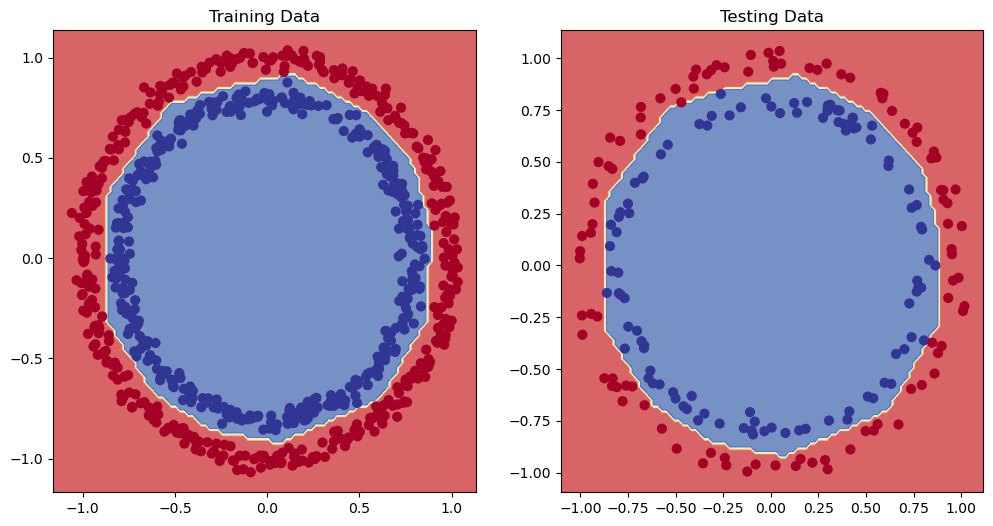

In [17]:
from helper_functions import plot_decision_boundary
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Training Data")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Testing Data")
plot_decision_boundary(model, X_test, y_test)